In [1]:
# Importerer pakker:
from extendedmodel import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Overview
The modelling is done with objects of the "Patient" class, which is implemented in extendedmodel.py.\
A lot of the basic utility is inherited from the "ODE" class, which is implemented in odeclass.py.

Objects of the Patient class can either use the MVP or the EHM model to run simulations. Each model has its own system of differential equations, accompanied with a set of parameters.\
The default values of all parameters - as well as intial state values - can be read and modified in the "config.json" file.
Defaults can be overridden through keyword arguments upon initialisation of the objects.

In [2]:
Healthy = Patient(0, model = "MVP", p2 = 0.15) # Non-diabetic person, using the MVP model, where the p2 parameter was overriden
T1 = Patient(1, model = "EHM", age = 22) # Type 1 diabetic person, using the Hovorka model, where the age parameter was overriden

Patients have a "patient_type" attribute, which determines whether they are healthy (patient_type=0), type 1 diabetic (patient_type=1) or type 2 diabetic (patient_type=2).\
The difference between them is their sources of insulin. 
Healthy patients do not have an insulin pump, whereas the diabetics do. 
The diabetics have reduced insulin secretion from their pancreas - reduced to zero for type 1 diabetics.


The pump and the pancreas are implemented as their own classes (which both inherit functionality from the "ODE" class).
Patients have properties which are instances of pump and/or pancreas objects.
The objects can be accessed directly (if applicable to patient_type).

In [3]:
T1.pumpObj # Healthy patients do not have this attribute.
Healthy.pancreasObj; # T1 diabetics do not have this attribute.

The pump() and pancreas() methods can be used to get the insulin secretion rate for a given glucose level.
For healthy patients, the pump() is simply a function that returns 0 regardless of input. Same goes for pancreas() of T1 diabetics.
Otherwise, the methods will update the state of the corresponding object, and return an insulin secretion rate.

In [4]:
G = 6
for i, t in enumerate(["Healthy", "T1 Diabetic", "T2 Diabetic"]):
    p = Patient(i, model = "EHM")
    print(f"{t}, for G = {G}:   \n Insulin pump secretion : {p.pump(G)} \n Pancreas insulin secretion : {p.pancreas(G)} ")

Healthy, for G = 6:   
 Insulin pump secretion : 0 
 Pancreas insulin secretion : 14.124748321216163 
T1 Diabetic, for G = 6:   
 Insulin pump secretion : 6.426430647 
 Pancreas insulin secretion : 0 
T2 Diabetic, for G = 6:   
 Insulin pump secretion : 6.426430647 
 Pancreas insulin secretion : 10.593561240912123 


# Simulations

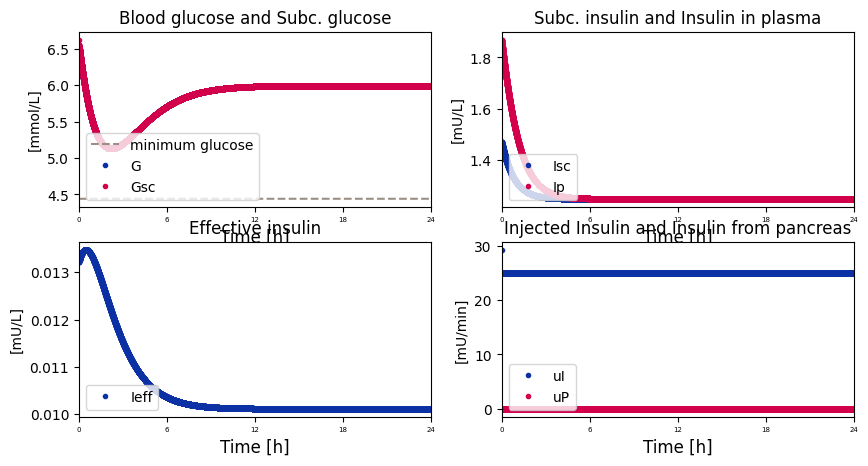

In [5]:
p_MVP = Patient(1, model = "MVP")
# Adds some noise to intial state
x = p_MVP.get_state()
x *= (0.5 * np.random.rand(len(x)) + 1)
p_MVP.update_state(x)
info = p_MVP.simulate()
p_MVP.statePlot(info, (2,2), (10, 5), [["G", "Gsc"], ["Isc", "Ip"], ["Ieff"], ["uI", "uP"]], 12)

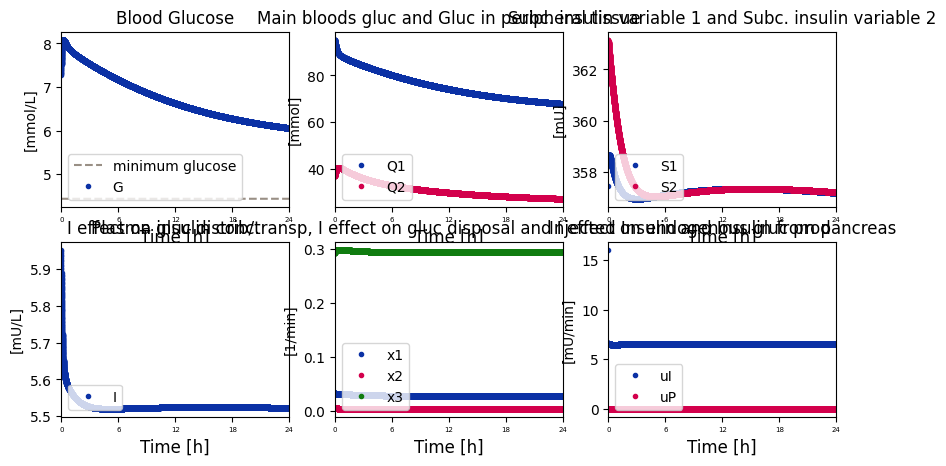

In [6]:
p_EHM = Patient(1, model = "EHM")
x = p_EHM.get_state()
x *= (0.5 * np.random.rand(len(x)) + 1)
p_EHM.update_state(x)
info = p_EHM.simulate()
p_EHM.statePlot(info, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)


To conveniently create a patient where the initial state is steady, the baseline_patient() function can be used.
Assuming no carb ingestion. it finds a state for which the derivative is 0 in the given system (EHM or MVP). 

If Gbar is given, the system will be solved such that G = Gbar at steady state.
Otherwise, the system will be solved such that a healthy person with the same parameters would be at steady state. That is, finding a glucose level where the insulin response (with the pancreas at steady state) maintains the level.

Parameters can be given as keyword arguments, and will default to the "usual" values. 

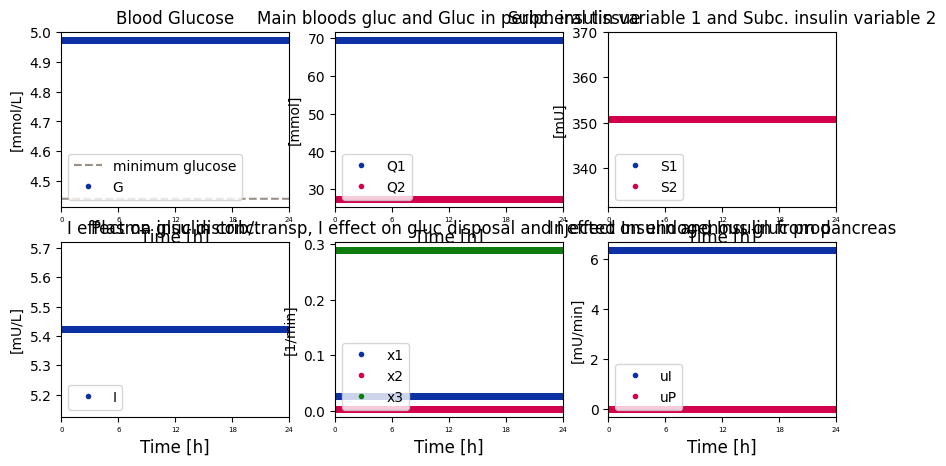

In [17]:
p = baseline_patient(1, model="EHM", VG = 0.2)
info = p.simulate()
p.statePlot(info, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)


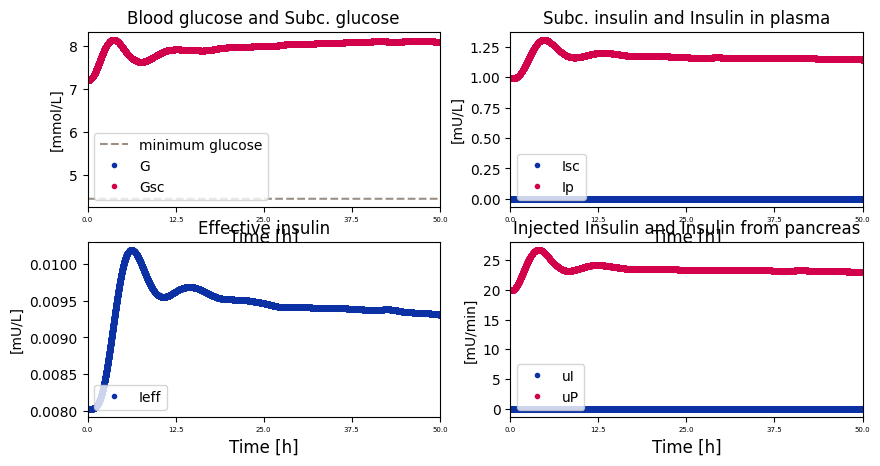

In [18]:
n = 30000
ds = ReLU(np.random.rand(n) * 0.01)

p_MVP = baseline_patient(0, model = "MVP")
info = p_MVP.simulate(ds)
p_MVP.statePlot(info, (2,2), (10, 5), [["G", "Gsc"], ["Isc", "Ip"], ["Ieff"], ["uI", "uP"]], 12)

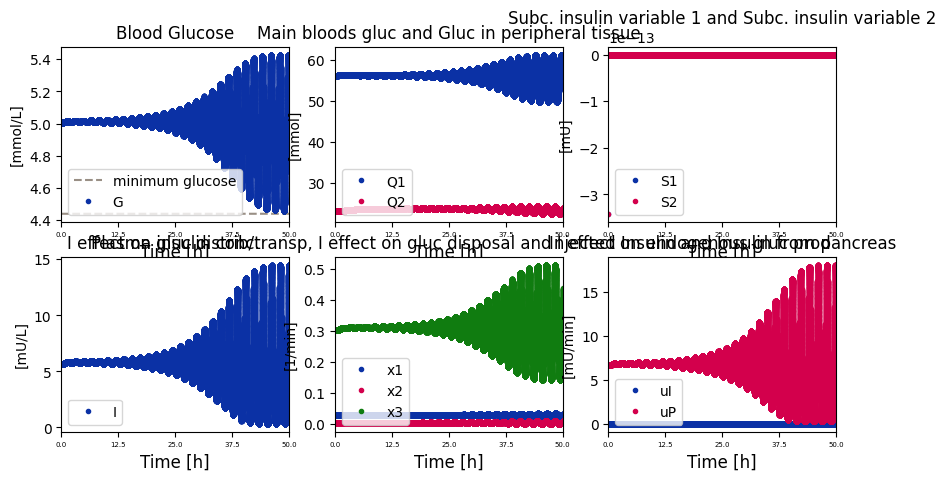

In [28]:
p_EHM = baseline_patient(0, model = "EHM")
info = p_EHM.simulate(ds)
p_EHM.statePlot(info, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)


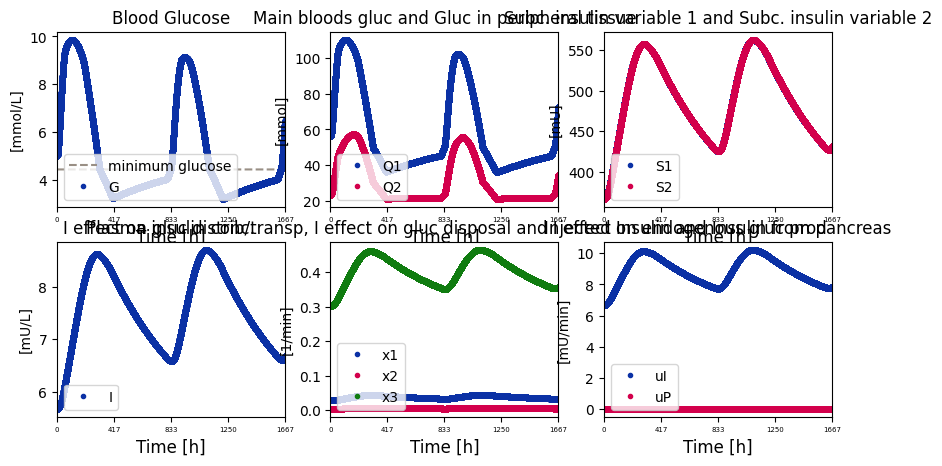

In [36]:
n = 100000
d = ReLU(np.sin(np.linspace(0,13,n))) / 8 # Funky eating patterns
p_EHM = baseline_patient(1, model = "EHM", timestep=1)
info = p_EHM.simulate(d)
p_EHM.statePlot(info, (2,3), (10, 5), [["G"],["Q1", "Q2"], ["S1", "S2"], ["I"], ["x1", "x2", "x3"], ["uI", "uP"]], 12)


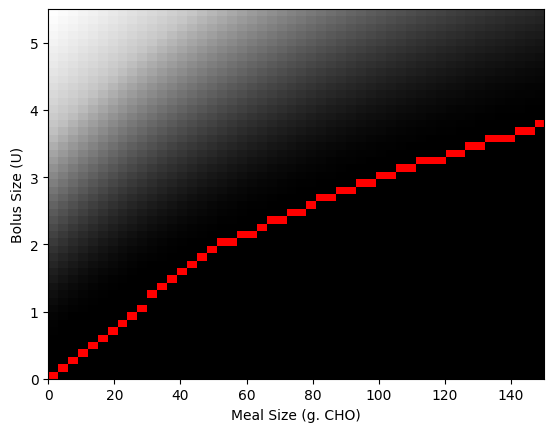

In [38]:
p_EHM = baseline_patient(1, model = "EHM", timestep=1)
n = int(10 * 60 / p_EHM.timestep)
meals, bolus, cost = p_EHM.optimal_bolus(min_meal = 0, max_U = 5.5, n = 50, iterations = n)
_, fun, _ = piecewise_linear_fit(meals, bolus)


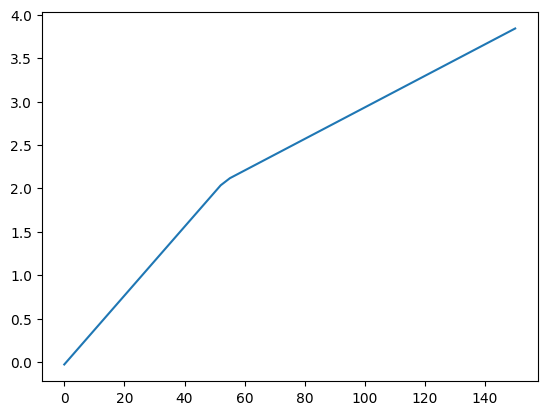

In [42]:
_, fun, _ = piecewise_linear_fit(meals, bolus)
plt.plot(meals,fun(meals))

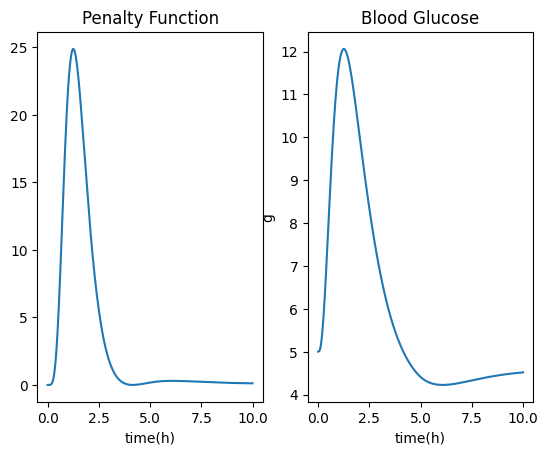

In [ ]:
p_EHM = Patient(1, model = "EHM", Gbar = Gbar_ehm)
hi = p_EHM.bolus_sim(3, 80, iterations = n, plot=True)

# About the implementation
The models are implemented through a class "MVPmodel", which is defined in the diabetesmodel.py file.

Objects of this class have some different attributes. Including initial values for the state, parameters for the simulation, tuning parameters, etc. 
The default values can be read and modified in the "config.json" file.

Defaults can be overridden through keyword arguments upon initialisation of the objects. 

In [ ]:
patient1 = MVPmodel() # Object with default values.
patient2 = MVPmodel(G = 120) # Object where G is initialised to be 120.
print("Different attributes and their defaults:")
pprint(patient1.__dict__)

Different attributes and their defaults:
{'C1': 20.1,
 'D1': 0,
 'D2': 0,
 'G': 108,
 'Gbar': 108,
 'Gmin': 70,
 'Gsc': 108,
 'Ieff': 0.0101028358,
 'Ip': 1.24726368,
 'Isc': 1.24726368,
 'Kp': 0.25,
 'S1': 0.0081,
 'Td': 15,
 'Ti': 500,
 'Vg': 253,
 'egp0': 1.33,
 'gezi': 0.0022,
 'kappa': 10000000.0,
 'p2': 0.0106,
 'tau1': 49,
 'tau2': 47,
 'taum': 47,
 'tausc': 5,
 'us': 25.1,
 'x': [0, 0, 1.24726368, 1.24726368, 0.0101028358, 108, 108],
 'x0': [0, 0, 1.24726368, 1.24726368, 0.0101028358, 108, 108]}


The value of the attributes can also be changed afterwards. Note that the "start state", x0, is defined upon initialisation.

In [ ]:
print(f"Object's 'G' value upon initialisation: {patient1.G}")
patient1.G = 130
print(f"Changed to: {patient1.G}")
patient1.reset()
print(f"After reset: {patient1.G}")

Object's 'G' value upon initialisation: 108
Changed to: 130
After reset: 108


# Simulations with given insulin injection rate
You can simulate a patient's state from their insulin injection rate and their carb ingestion rate, using the "simulate" method.

The simulate method has the input parameter "u_func", which, if given, can either be an array, a number, or "PID".
If unspecified, the injection rate will default to the object's "us" attribute (steady state insulin).

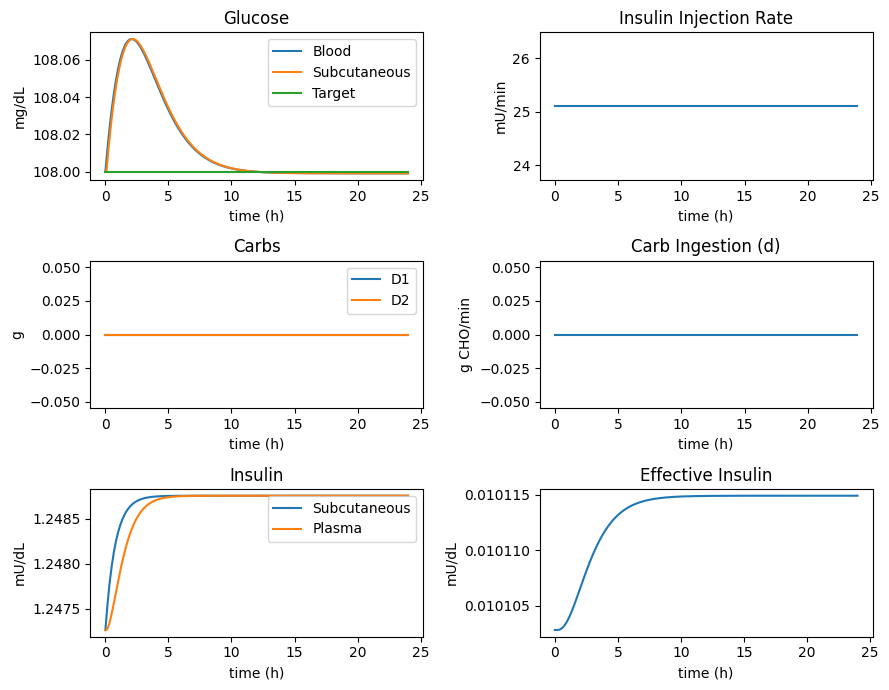

In [ ]:
patient1.reset()
n = (24 * 60)//patient1.tausc # Number of timesteps for a 24h simulation. The parameter "tausc" is the length of a timestep in minutes. 

d_list = np.zeros(n) # No carbs

states, u_list = patient1.simulate(d_list) # Runs simulation. Returns a matrix containing the state during simulation, and a list of injection rates.
patient1.plot(states, u_list, d_list) #  Plotting

# Simulations with PID-controller
Using the simulate method, with u_func as "PID", you can run simulations where the insulin injection rate is administrated by a PID-controller.

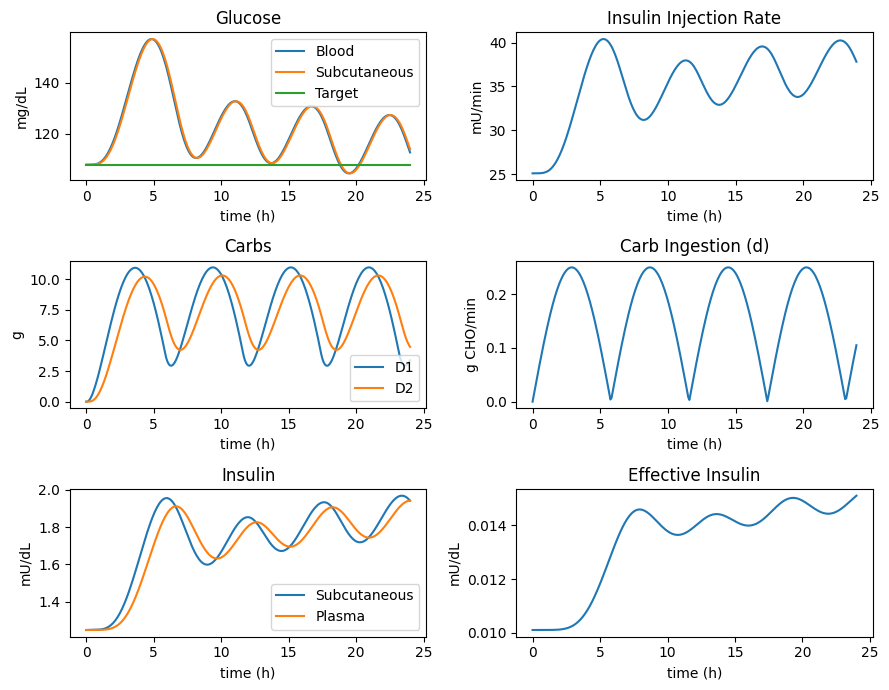

In [ ]:
patient1.reset()
d = np.abs(np.sin(np.linspace(0,13,n))) / 4 # Funky eating patterns
states, u = patient1.simulate(d, u_func="PID")
patient1.plot(states, u, d)

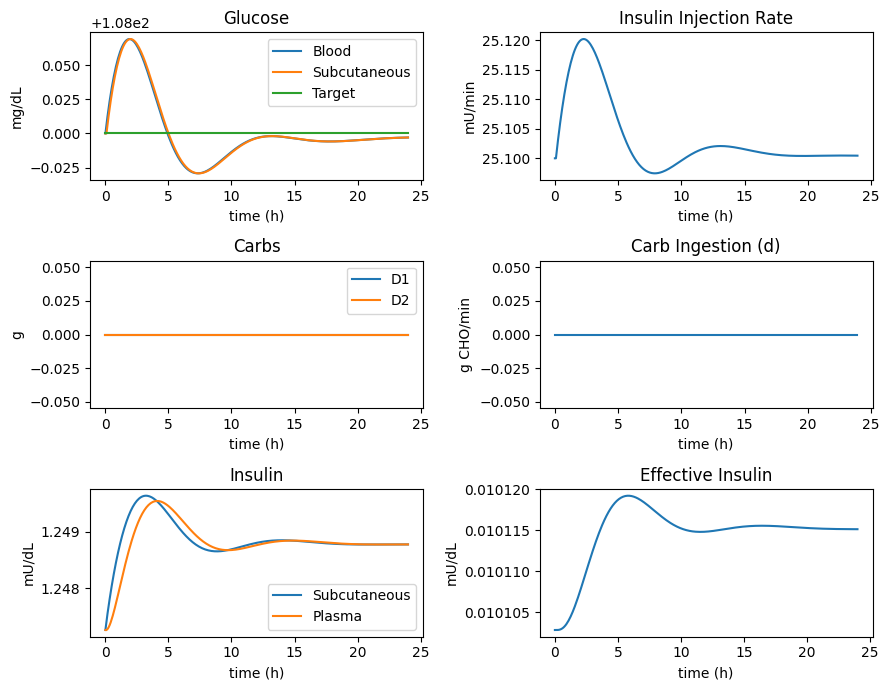

In [ ]:
patient1.reset()
d = np.zeros(n)
states, u = patient1.simulate(d, u_func="PID")
patient1.plot(states, u, d)

# Bolus size
Given an insulin bolus size (measured in "U") and the number of carbs in a meal, "bolus_sim" simulates the patient's state, and returns the integral of the penalty function, the values of the penalty function, and the blood glucose in every time step.

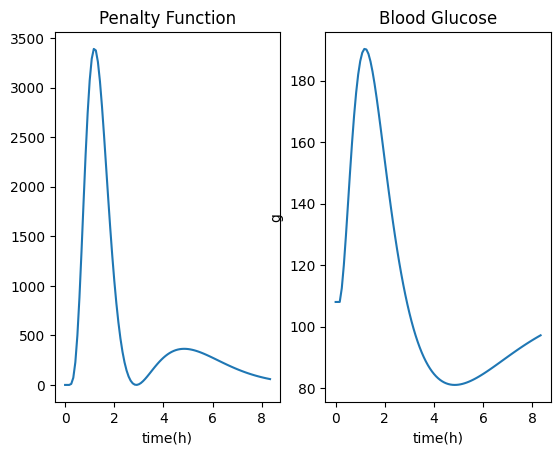

In [ ]:
patient1.reset()
phi, p, Gt = patient1.bolus_sim(8, 100, 0, plot=True) # Bolus of 10 U, and meal of 75 g carbs.

You can iterate through these simulations with the "optimal_bolus" method, which generates a (very boring looking) heatplot, where the colour of each pixel indicates the integral of the penalty function. The minimum values are indicated with red.

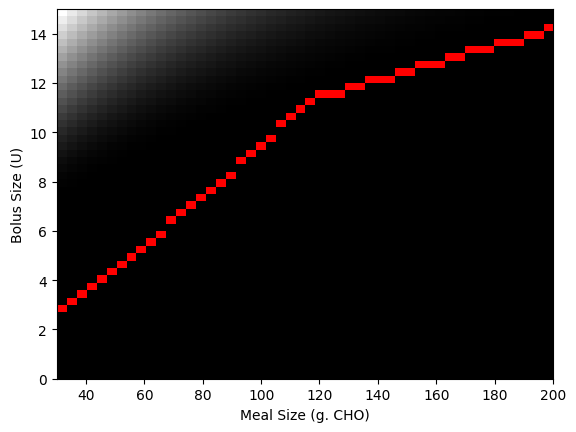

In [ ]:
patient1.reset()

meals, best_us = patient1.optimal_bolus(meal_idx = 0, min_U = 0, max_U = 15, max_meal = 200, n = 50)

A piecewise linear fit can be fitted to the data, using the "piecewise_linear_fit", from "fitting.py".

In [ ]:
_, fun, _ = piecewise_linear_fit(meals, best_us)

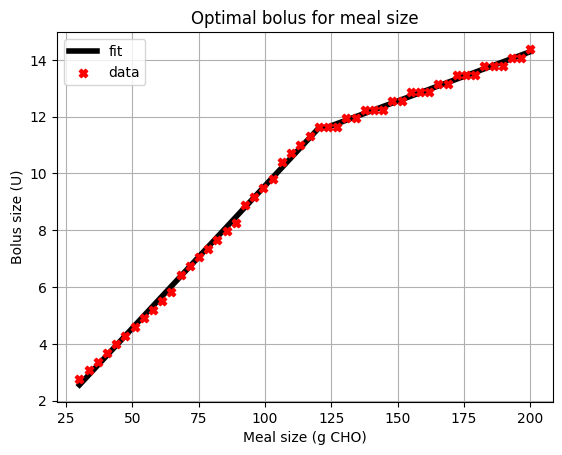

In [ ]:
plt.plot(meals, fun(meals), linewidth=4, color="black",label="fit")
plt.scatter(meals, best_us, color="red", zorder=2, marker="X", label="data")
plt.grid("gray")
plt.legend()
plt.title("Optimal bolus for meal size")
plt.xlabel("Meal size (g CHO)")
plt.ylabel("Bolus size (U)");